#**스마트폰 센서 데이터 기반 모션 분류**
# 단계2 : 기본 모델링


## 0.미션

* 데이터 전처리
    * 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리 수행
* 다양한 알고리즘으로 분류 모델 생성
    * 최소 4개 이상의 알고리즘을 적용하여 모델링 수행
    * 성능 비교
    * 각 모델의 성능을 저장하는 별도 데이터 프레임을 만들고 비교
* 옵션 : 다음 사항은 선택사항입니다. 시간이 허용하는 범위 내에서 수행하세요.
    * 상위 N개 변수를 선정하여 모델링 및 성능 비교
        * 모델링에 항상 모든 변수가 필요한 것은 아닙니다.
        * 변수 중요도 상위 N개를 선정하여 모델링하고 타 모델과 성능을 비교하세요.
        * 상위 N개를 선택하는 방법은, 변수를 하나씩 늘려가며 모델링 및 성능 검증을 수행하여 적절한 지점을 찾는 것입니다.

## 1.환경설정

### (1) 라이브러리 불러오기

* 세부 요구사항
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
    - 필요하다고 판단되는 라이브러리를 추가하세요.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder

from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.backend import clear_session
from keras.optimizers import Adam

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


* 함수 생성

In [3]:
# 변수의 특성 중요도 계산하기
def plot_feature_importance(importance, names, result_only = False, topn = 'all'):
    feature_importance = np.array(importance)
    feature_name = np.array(names)

    data={'feature_name':feature_name,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    #변수의 특성 중요도 순으로 정렬하기
    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    #변수의 특성 중요도 그래프로 그리기
    if result_only == False :
        plt.figure(figsize=(10,20))
        sns.barplot(x='feature_importance', y='feature_name', data = fi_df)

        plt.xlabel('importance')
        plt.ylabel('feature name')
        plt.grid()

    return fi_df

### (2) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
* 세부 요구사항
    - 전체 데이터 'data01_train.csv' 를 불러와 'data' 이름으로 저장합니다.
        - data에서 변수 subject는 삭제합니다.
    - 데이터프레임에 대한 기본 정보를 확인합니다.( .head(), .shape 등)

#### 1) 데이터 로딩

In [4]:
data = pd.read_csv('./drive/MyDrive/AIVLE/7. 미니프로젝트 3차/data01_train.csv')

In [5]:
data.drop('subject', axis=1, inplace=True)

#### 2) 기본 정보 조회

In [6]:
data.shape

(5881, 562)

In [7]:
data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS


In [8]:
data.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,...,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,0.274811,-0.017799,-0.109396,-0.603138,-0.509815,-0.604058,-0.628151,-0.525944,-0.605374,-0.465490,...,0.126955,-0.305883,-0.623548,0.008524,-0.001185,0.009340,-0.007099,-0.491501,0.059299,-0.054594
std,0.067614,0.039422,0.058373,0.448807,0.501815,0.417319,0.424345,0.485115,0.413043,0.544995,...,0.249176,0.322808,0.310371,0.339730,0.447197,0.608190,0.476738,0.509069,0.297340,0.278479
min,-0.503823,-0.684893,-1.000000,-1.000000,-0.999844,-0.999667,-1.000000,-0.999419,-1.000000,-1.000000,...,-0.965725,-0.979261,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.980143
25%,0.262919,-0.024877,-0.121051,-0.992774,-0.977680,-0.980127,-0.993602,-0.977865,-0.980112,-0.936067,...,-0.021610,-0.541969,-0.845985,-0.122361,-0.294369,-0.481718,-0.373345,-0.811397,-0.018203,-0.141555
50%,0.277154,-0.017221,-0.108781,-0.943933,-0.844575,-0.856352,-0.948501,-0.849266,-0.849896,-0.878729,...,0.133887,-0.342923,-0.712677,0.010278,0.005146,0.011448,-0.000847,-0.709441,0.182893,0.003951
75%,0.288526,-0.010920,-0.098163,-0.242130,-0.034499,-0.262690,-0.291138,-0.068857,-0.268539,-0.013690,...,0.288944,-0.127371,-0.501158,0.154985,0.285030,0.499857,0.356236,-0.511330,0.248435,0.111932
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,0.977344,0.478157,1.000000


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881 entries, 0 to 5880
Columns: 562 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), object(1)
memory usage: 25.2+ MB


In [10]:
data.isna().sum().sum()

0

## **2. 데이터 전처리**

* 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리를 수행한다.


### (1) 데이터 분할1 : x, y

* 세부 요구사항
    - x, y로 분할합니다.

### (2) 스케일링(필요시)


* 세부 요구사항
    - 스케일링을 필요로 하는 알고리즘 사용을 위해서 코드 수행
    - min-max 방식 혹은 standard 방식 중 한가지 사용.

In [11]:
# sclaer = MinMaxScaler()
# x_train_scaled = sclaer.fit_transform(x_train)
# x_val_scaled = sclaer.transform(x_train)

### (3) 데이터분할2 : train, validation

* 세부 요구사항
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 합니다.

In [12]:
target = 'Activity'
x = data.drop(target, axis=1)
y = data.loc[:, target]

In [13]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=327)

## **3. 기본 모델링**



* 세부 요구사항
    - 최소 4개 이상의 알고리즘을 적용하여 모델링을 수행한다.
    - 각 알고리즘별로 전체 변수로 모델링, 상위 N개 변수를 선택하여 모델링을 수행하고 성능 비교를 한다.
    - (옵션) 알고리즘 중 1~2개에 대해서, 변수 중요도 상위 N개를 선정하여 모델링하고 타 모델과 성능을 비교.
        * 상위 N개를 선택하는 방법은, 변수를 하나씩 늘려가며 모델링 및 성능 검증을 수행하여 적절한 지점을 찾는 것이다.

### (1) 알고리즘1 : 랜덤 포레스트

In [14]:
model1 = RandomForestClassifier()

In [15]:
model1.fit(x_train, y_train)

RandomForestClassifier()

In [16]:
pred1 = model1.predict(x_val)

In [17]:
print(confusion_matrix(y_val, pred1))
print(classification_report(y_val, pred1))

[[217   0   0   0   0   0]
 [  0 197  12   0   0   0]
 [  0   6 200   0   0   0]
 [  0   0   0 231   3   3]
 [  0   0   0   2 113   1]
 [  0   0   0   0   0 192]]
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       217
           SITTING       0.97      0.94      0.96       209
          STANDING       0.94      0.97      0.96       206
           WALKING       0.99      0.97      0.98       237
WALKING_DOWNSTAIRS       0.97      0.97      0.97       116
  WALKING_UPSTAIRS       0.98      1.00      0.99       192

          accuracy                           0.98      1177
         macro avg       0.98      0.98      0.98      1177
      weighted avg       0.98      0.98      0.98      1177



### (2) 알고리즘2 : 서포트 벡터 머신

In [18]:
model2 = SVC()

In [19]:
model2.fit(x_train, y_train)

SVC()

In [20]:
pred2 = model2.predict(x_val)

In [21]:
print(confusion_matrix(y_val, pred2))
print(classification_report(y_val, pred2))

[[217   0   0   0   0   0]
 [  2 190  17   0   0   0]
 [  0  16 190   0   0   0]
 [  0   0   0 236   0   1]
 [  0   0   0   0 115   1]
 [  0   0   0   1   2 189]]
                    precision    recall  f1-score   support

            LAYING       0.99      1.00      1.00       217
           SITTING       0.92      0.91      0.92       209
          STANDING       0.92      0.92      0.92       206
           WALKING       1.00      1.00      1.00       237
WALKING_DOWNSTAIRS       0.98      0.99      0.99       116
  WALKING_UPSTAIRS       0.99      0.98      0.99       192

          accuracy                           0.97      1177
         macro avg       0.97      0.97      0.97      1177
      weighted avg       0.97      0.97      0.97      1177



### (3) 알고리즘3 : K최근접이웃

In [22]:
model3 = KNeighborsClassifier(n_neighbors=5)

In [23]:
model3.fit(x_train, y_train)

KNeighborsClassifier()

In [24]:
pred3 = model3.predict(x_val)

In [25]:
print(confusion_matrix(y_val, pred3))
print(classification_report(y_val, pred3))

[[217   0   0   0   0   0]
 [  2 176  31   0   0   0]
 [  0  18 188   0   0   0]
 [  0   0   0 237   0   0]
 [  0   0   0   0 114   2]
 [  0   0   0   0   0 192]]
                    precision    recall  f1-score   support

            LAYING       0.99      1.00      1.00       217
           SITTING       0.91      0.84      0.87       209
          STANDING       0.86      0.91      0.88       206
           WALKING       1.00      1.00      1.00       237
WALKING_DOWNSTAIRS       1.00      0.98      0.99       116
  WALKING_UPSTAIRS       0.99      1.00      0.99       192

          accuracy                           0.95      1177
         macro avg       0.96      0.96      0.96      1177
      weighted avg       0.96      0.95      0.95      1177



### (4) 알고리즘4 : 딥러닝 다중분류 모델

In [26]:
data[target] = data[target].map({'STANDING':0, 'SITTING':1, 'LAYING':2, 'WALKING':3, 'WALKING_UPSTAIRS':4, 'WALKING_DOWNSTAIRS':5})

In [27]:
x = data.drop(target, axis=1)
y = data.loc[:, target]
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=327)

In [28]:
sclaer = MinMaxScaler()
x_train_scaled = sclaer.fit_transform(x_train)
x_val_scaled = sclaer.transform(x_train)

In [29]:
nfeatures = x_train.shape[1]
nfeatures

561

In [30]:
clear_session()
model4 = Sequential([Dense(64, input_shape = (nfeatures, ), activation='relu'),
                     Dense(48, activation='relu'),
                     Dense(32, activation='relu'),
                     Dense(16, activation='relu'),
                     Dense(8, activation='relu'),
                     Dense(6, activation='softmax')])
model4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                35968     
                                                                 
 dense_1 (Dense)             (None, 48)                3120      
                                                                 
 dense_2 (Dense)             (None, 32)                1568      
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 8)                 136       
                                                                 
 dense_5 (Dense)             (None, 6)                 54        
                                                                 
Total params: 41374 (161.62 KB)
Trainable params: 41374 

In [31]:
model4.compile(optimizer=Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy')
model4.fit(x_train, y_train, epochs=100, validation_split=0.2)

Epoch 1/100
118/118 [==============================] - 2s 5ms/step - loss: 0.9051 - val_loss: 0.3181
Epoch 2/100
118/118 [==============================] - 0s 3ms/step - loss: 0.3313 - val_loss: 0.2077
Epoch 3/100
118/118 [==============================] - 0s 3ms/step - loss: 0.2226 - val_loss: 0.1669
Epoch 4/100
118/118 [==============================] - 1s 5ms/step - loss: 0.1818 - val_loss: 0.2974
Epoch 5/100
118/118 [==============================] - 1s 6ms/step - loss: 0.2002 - val_loss: 0.1565
Epoch 6/100
118/118 [==============================] - 1s 9ms/step - loss: 0.1554 - val_loss: 0.4238
Epoch 7/100
118/118 [==============================] - 1s 6ms/step - loss: 0.1735 - val_loss: 0.1154
Epoch 8/100
118/118 [==============================] - 1s 6ms/step - loss: 0.1042 - val_loss: 0.1970
Epoch 9/100
118/118 [==============================] - 1s 7ms/step - loss: 0.1008 - val_loss: 0.0687
Epoch 10/100
118/118 [==============================] - 1s 7ms/step - loss: 0.1015 - val_lo

In [32]:
pred4 = model4.predict(x_val)
pred4 = pred4.argmax(axis=1)

37/37 [==============================] - 0s 2ms/step


In [33]:
print(confusion_matrix(y_val, pred4))
print(classification_report(y_val, pred4))

[[197   9   0   0   0   0]
 [  8 201   0   0   0   0]
 [  0   0 217   0   0   0]
 [  0   0   0 233   2   2]
 [  0   0   0   3 188   1]
 [  0   0   0   0   0 116]]
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       206
           1       0.96      0.96      0.96       209
           2       1.00      1.00      1.00       217
           3       0.99      0.98      0.99       237
           4       0.99      0.98      0.98       192
           5       0.97      1.00      0.99       116

    accuracy                           0.98      1177
   macro avg       0.98      0.98      0.98      1177
weighted avg       0.98      0.98      0.98      1177



## **4. 추가 모델링(옵션)**



### (1) 변수 중요도 찾기

In [36]:
data = pd.read_csv('./drive/MyDrive/AIVLE/7. 미니프로젝트 3차/data01_train.csv')

In [37]:
data.drop('subject', axis=1, inplace=True)

In [38]:
x = data.drop(target, axis=1)
y = data.loc[:, target]

In [39]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=327)

In [40]:
model = RandomForestClassifier()

In [41]:
model.fit(x_train, y_train)

RandomForestClassifier()

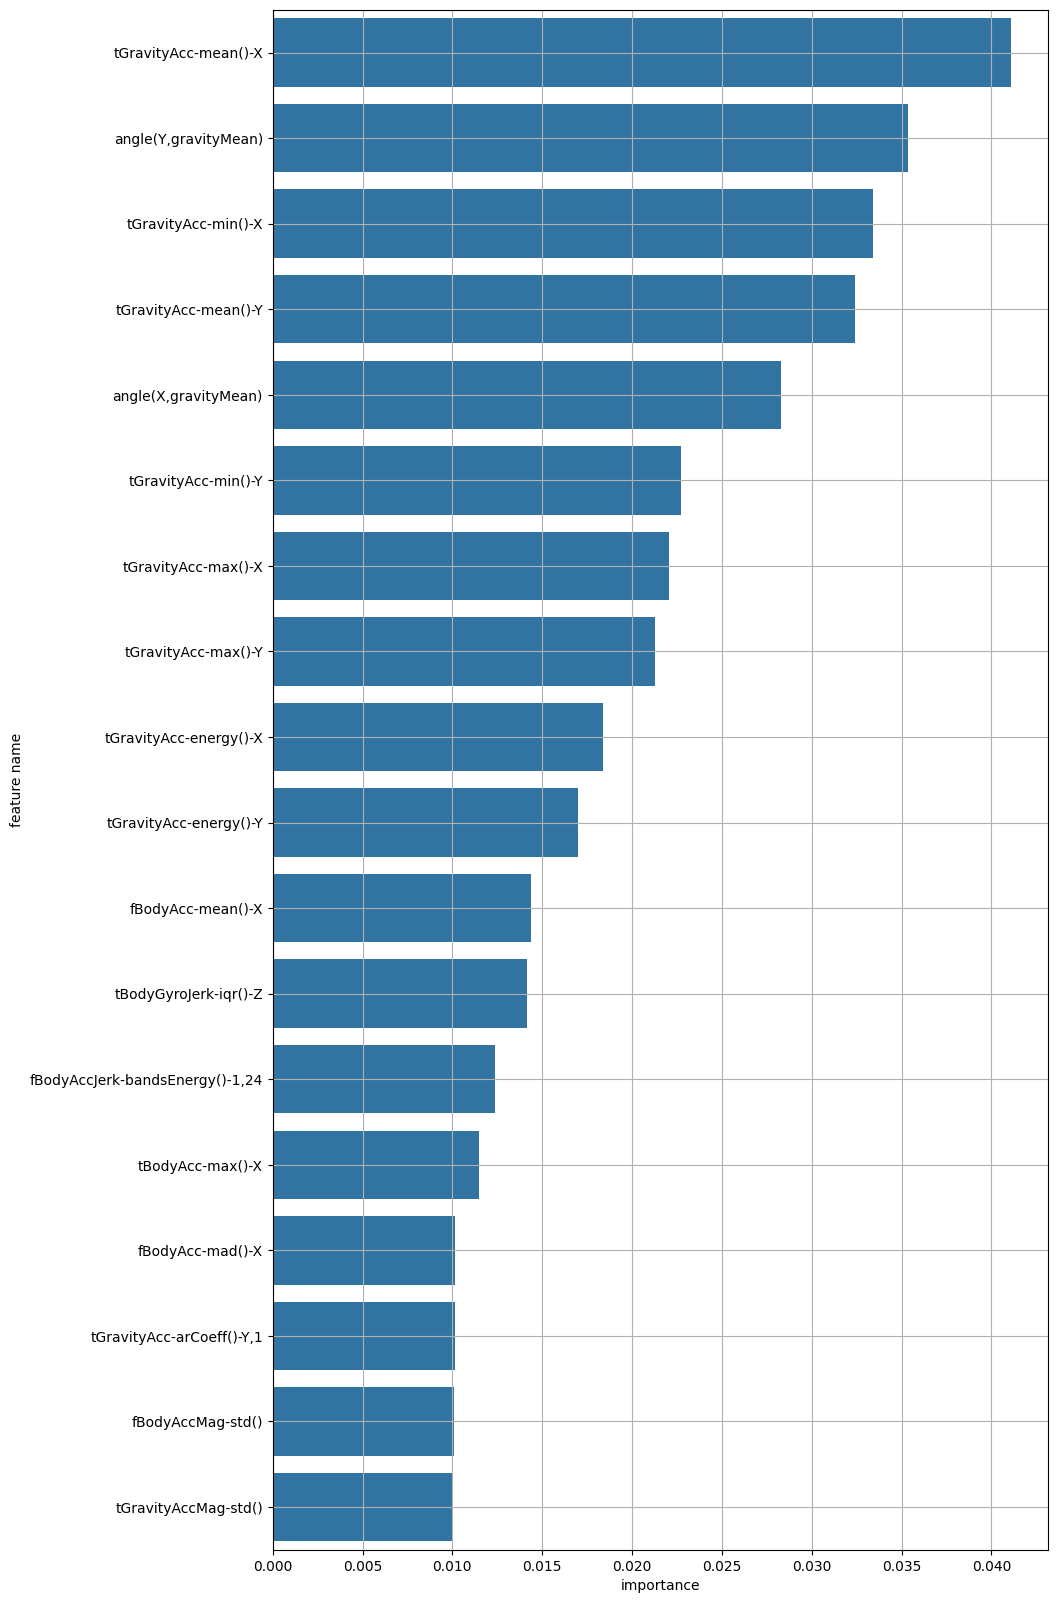

In [42]:
feature_importances = plot_feature_importance(model.feature_importances_, x_train.columns, False, 18)

### (2) 딥러닝 모델링

In [43]:
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

In [44]:
temp = data.copy()
temp[target] = temp[target].map({'STANDING':0, 'SITTING':1, 'LAYING':2, 'WALKING':3, 'WALKING_UPSTAIRS':4, 'WALKING_DOWNSTAIRS':5})

In [45]:
x = temp.loc[:, feature_importances['feature_name']]
y = temp.loc[:, target]
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=327)

In [46]:
sclaer = MinMaxScaler()
x_train_scaled = sclaer.fit_transform(x_train)
x_val_scaled = sclaer.transform(x_val)

In [47]:
nfeatures = x_train.shape[1]
nfeatures

18

In [53]:
clear_session()
model5 = Sequential([Dense(256, input_shape = (nfeatures, ), activation='relu'),
                     Dense(128, activation='relu'),
                     Dense(64, activation='relu'),
                     Dense(32, activation='relu'),
                     Dense(16, activation='relu'),
                     Dense(6, activation='softmax')])
model5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               4864      
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dense_5 (Dense)             (None, 6)                 102       
                                                                 
Total params: 48726 (190.34 KB)
Trainable params: 48726 

In [54]:
model5.compile(optimizer=Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy')
hist = model5.fit(x_train, y_train, epochs=100, validation_split=0.2).history

Epoch 1/100
118/118 [==============================] - 3s 7ms/step - loss: 0.5520 - val_loss: 0.2910
Epoch 2/100
118/118 [==============================] - 1s 4ms/step - loss: 0.2729 - val_loss: 0.3576
Epoch 3/100
118/118 [==============================] - 1s 4ms/step - loss: 0.2803 - val_loss: 0.2169
Epoch 4/100
118/118 [==============================] - 1s 5ms/step - loss: 0.2431 - val_loss: 0.2008
Epoch 5/100
118/118 [==============================] - 1s 5ms/step - loss: 0.2108 - val_loss: 0.2492
Epoch 6/100
118/118 [==============================] - 0s 4ms/step - loss: 0.2213 - val_loss: 0.2499
Epoch 7/100
118/118 [==============================] - 0s 3ms/step - loss: 0.2318 - val_loss: 0.2415
Epoch 8/100
118/118 [==============================] - 0s 3ms/step - loss: 0.3047 - val_loss: 0.2117
Epoch 9/100
118/118 [==============================] - 0s 3ms/step - loss: 0.2132 - val_loss: 0.1864
Epoch 10/100
118/118 [==============================] - 0s 3ms/step - loss: 0.2233 - val_lo

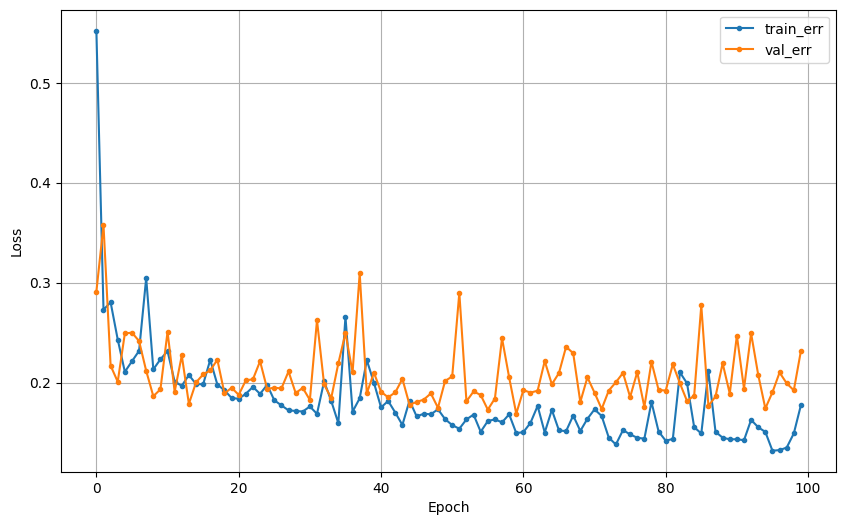

In [55]:
dl_history_plot(hist)

In [56]:
pred5 = model5.predict(x_val)
pred5 = pred5.argmax(axis=1)

37/37 [==============================] - 0s 2ms/step


In [57]:
print(confusion_matrix(y_val, pred5))
print(classification_report(y_val, pred5))

[[203   3   0   0   0   0]
 [ 81 127   0   0   1   0]
 [  0   0 217   0   0   0]
 [  0   0   0 227   8   2]
 [  0   0   0   4 184   4]
 [  0   0   0   1   6 109]]
              precision    recall  f1-score   support

           0       0.71      0.99      0.83       206
           1       0.98      0.61      0.75       209
           2       1.00      1.00      1.00       217
           3       0.98      0.96      0.97       237
           4       0.92      0.96      0.94       192
           5       0.95      0.94      0.94       116

    accuracy                           0.91      1177
   macro avg       0.92      0.91      0.91      1177
weighted avg       0.92      0.91      0.90      1177

